In [1]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import mlflow
from db_connect import Db_connect
from recommendation_system import Recommendation
import warnings

%load_ext autoreload
%autoreload 2

In [2]:
data_path = cr.DATA_PATH

db = Db_connect()
rc = Recommendation()

warnings.filterwarnings("ignore")
mlflow.sklearn.autolog()

In [3]:
db.init_connection()
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

## MVP0

In [25]:
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features, top_30_titles)

train_test_dataset = track_features.copy()
train_test_dataset['playlist'] = train_test_dataset.apply(lambda x: int(x.name in top_30_titles.index), axis=1)

classifier_data = train_test_dataset.copy()
classifier_data = classifier_data.sort_values(['playlist'], ascending=False).head(100)

classifier_target = classifier_data['playlist']

# classifier_data = classifier_data.drop('loudness',axis = 1)
classifier_data = classifier_data.drop('playlist', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_target, test_size=0.3, random_state=42)

In [26]:
track_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
3tyTt5pEWblt96j1HsXiV5,0.000030,0.000030,5,0.0,1,0.000028,0.000028,0.000028,0.000028,0.000030,0.000262,1.0,4
0HEmnAUT8PHznIAAmVXqFJ,0.000067,0.000065,11,0.0,1,0.000063,0.000062,0.000062,0.000062,0.000065,0.000558,1.0,4
0DJnqFhVWoTDs58JPem5Zh,0.000030,0.000031,2,0.0,1,0.000027,0.000027,0.000027,0.000028,0.000030,0.000493,1.0,4
5MWKU5MnIuv5uQez4n0byz,0.000038,0.000037,5,0.0,0,0.000034,0.000035,0.000036,0.000034,0.000037,0.000490,1.0,4
029NqmIySn1kOY305AAhxT,0.000019,0.000019,1,0.0,1,0.000017,0.000017,0.000017,0.000017,0.000018,0.000324,1.0,4


In [27]:
knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

2022/02/05 00:23:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd3077b3f717f4d99b6252cfca00a09b4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Accuracy: 0.6666666666666666


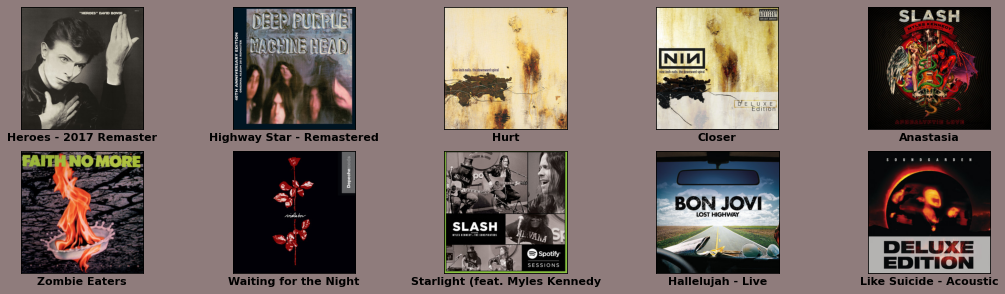

,name,proba
id,,
7Jh1bpe76CNTCgdgAdBw4Z,Heroes - 2017 Remaster,1.0
3uMmllZo1AfoEnVT4ENCD3,Highway Star - Remastered 2012,1.0
27tX58NOpv1YKQ0abW7EPy,Hurt,1.0
5mc6EyF1OIEOhAkD0Gg9Lc,Closer,1.0
3jaJeSphs7bS5Gt3i5LJL3,Anastasia,1.0
1dwg5WIMZLUT9tkc1FsNYX,Zombie Eaters,1.0
1VEIMGVXj7713dHY9gZLyU,Waiting for the Night,1.0
6lvQzrVGg9i8vzz71WWSF2,Starlight (feat. Myles Kennedy and The Conspir...,1.0
2vTPnVToPdKP4W1irOlhz5,Hallelujah - Live,1.0


In [73]:
recommendation = nonplaylist.copy()

recommendation['predict'] = recommendation.apply(lambda x: knn.predict([x])[0], axis=1)
recommendation['proba'] = recommendation.loc[:, recommendation.columns != 'predict'].apply(lambda x: knn.predict_proba([x])[0].max(), axis=1)

recommendation = recommendation[recommendation['predict']==1]
recommendation = recommendation.sort_values('proba', ascending=False).head(10)

recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)
rc.visualize_cover(recommendation)

display(recommendation[['name', 'proba']])

## Process data & data split

In [4]:
track_features_processed = rc.process_data(track_features)
playlist, nonplaylist = rc.generate_playlist_nonplaylist(track_features_processed, top_30_titles)

train_test_dataset = track_features_processed.copy()
train_test_dataset['playlist'] = train_test_dataset.apply(lambda x: int(x.name in top_30_titles.index), axis=1)

classifier_data = train_test_dataset.copy()
classifier_data = classifier_data.sort_values(['playlist'], ascending=False).head(100)

classifier_target = classifier_data['playlist']

# classifier_data = classifier_data.drop('loudness',axis = 1)
classifier_data = classifier_data.drop('playlist',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(classifier_data, classifier_target, test_size=0.3, random_state=42)

In [76]:
track_features_processed.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,...,time_signature_4,time_signature_5,decade_195,decade_196,decade_197,decade_198,decade_199,decade_200,decade_201,decade_202
id,,,,,,,,,,,,,,,,,,,,,
3tyTt5pEWblt96j1HsXiV5,0.677,0.852,-10.856,0.0450,0.2250,0.000039,0.0595,0.930,91.691,6.514367,...,1,0,0,0,0,0,0,0,1,0
0HEmnAUT8PHznIAAmVXqFJ,0.887,0.480,-11.994,0.1170,0.0094,0.000036,0.0662,0.607,95.846,3.220000,...,1,0,0,0,0,1,0,0,0,0
0DJnqFhVWoTDs58JPem5Zh,0.698,0.910,-6.563,0.0459,0.0190,0.000077,0.1100,0.715,112.112,4.011767,...,1,0,0,0,0,0,1,0,0,0
5MWKU5MnIuv5uQez4n0byz,0.852,0.591,-8.668,0.0675,0.1030,0.421000,0.0468,0.826,115.592,4.222883,...,1,0,0,0,0,0,1,0,0,0
029NqmIySn1kOY305AAhxT,0.657,0.685,-5.203,0.0334,0.0246,0.000000,0.0370,0.424,96.458,5.225550,...,1,0,0,0,0,1,0,0,0,0


## RandomizedSearchCV

In [5]:
algorithm = ['ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis', 'cosine', 'jaccard']
# n = list(range(1, 20))

params = { 'algorithm': algorithm, 'weights': weights, 'metric': metric }

In [6]:
RSCV = RandomizedSearchCV(KNeighborsClassifier(), params, random_state=42)
RSCV.fit(X_train, y_train)

2022/02/05 20:10:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a18a8a92b7514793a7594b6d0c87381d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/02/05 20:10:32 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.


RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski',
                                                   'wminkowski', 'seuclidean',
                                                   'mahalanobis', 'cosine',
                                                   'jaccard'],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [7]:
RSCV.best_params_

{'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'ball_tree'}

## Finding the right K

In [135]:
error_rate_knn = []
accuracy_knn = []

for i in range(1,15):

    # kNN
    knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute', weights='distance', metric='manhattan')
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)

    error_rate_knn.append(np.mean(y_pred != y_test))
    accuracy_knn.append(metrics.accuracy_score(y_test, y_pred))

2022/02/04 23:58:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd3c3f300eaf64597bd274b5fcb397731', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/02/04 23:58:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c87e86e03df644b2826a7e83d812f59f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/02/04 23:58:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f0a9d243b9814c94a668d6ca10994e5e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/02/04 23:58:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ff38e74b870c466fbae7894ee099e7ba', which will track hyperparameters, performance metrics, model artifacts, and lineage i

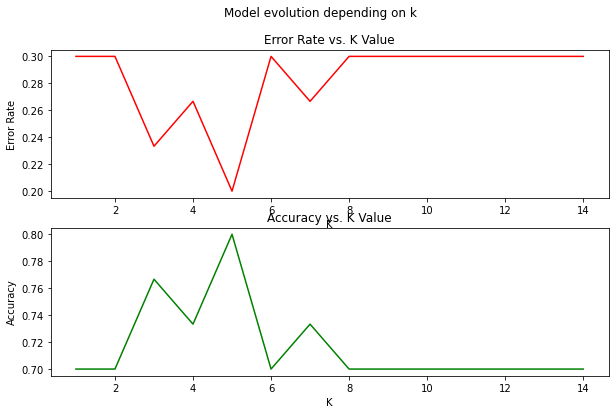

In [136]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
fig.suptitle('Model evolution depending on k')

ax1.plot(range(1,15),error_rate_knn,color='red')
ax1.set_title('Error Rate vs. K Value')
ax1.set_xlabel('K')
ax1.set_ylabel('Error Rate')

ax2.plot(range(1,15),accuracy_knn,color='green')
ax2.set_title('Accuracy vs. K Value')
ax2.set_xlabel('K')
ax2.set_ylabel('Accuracy')

plt.show()

## Recommandation finale

In [134]:
knn = KNeighborsClassifier(n_neighbors=5, algorithm='brute', weights='distance', metric='manhattan')

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

2022/02/04 23:57:25 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e4f6258d13547d997ed30a284a22371', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Accuracy: 0.8


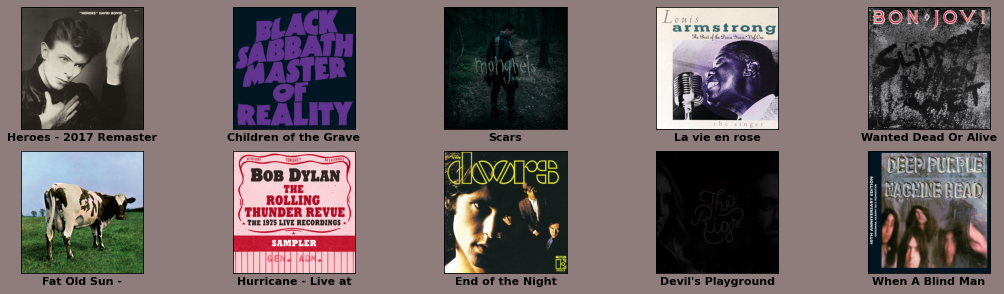

,name,proba
id,,
7Jh1bpe76CNTCgdgAdBw4Z,Heroes - 2017 Remaster,0.822630
3ZuVfQriS93y6ofwbIf7lp,Children of the Grave,0.811430
6ctGf5r6PEsUvN0msqOV9W,Scars,0.805088
1UH4viviUjZnS9aWgPGrk0,La vie en rose - Single Version,0.729384
2fY6tqgrlrg1ky9fgs0t5u,Wanted Dead Or Alive,0.728611
7BgCcmvjRx5fDyJXn2GbxU,Fat Old Sun - 2011 Remastered Version,0.708555
3tydlYMRrQPki1X97cfvJ5,"Hurricane - Live at Boston Music Hall, Boston,...",0.706855
09ezgACZuwWZt6CtQSSLRG,End of the Night,0.693926
3WdHywW5eesvHX9pj5z8eT,Devil's Playground,0.691610


In [102]:
recommendation = nonplaylist.copy()

recommendation['predict'] = recommendation.apply(lambda x: knn.predict([x])[0], axis=1)
recommendation['proba'] = recommendation.loc[:, recommendation.columns != 'predict'].apply(lambda x: knn.predict_proba([x])[0].max(), axis=1)

recommendation = recommendation[recommendation['predict']==1]
recommendation = recommendation.sort_values('proba', ascending=False).head(10)

recommendation = recommendation.merge(track_titles, left_index=True, right_index=True)
rc.visualize_cover(recommendation)

display(recommendation[['name', 'proba']])

## Add to the database

In [104]:
recommendation['playlist'] = '6AsIwsN6mH7dQSChLsqSlY'
recommendation[['proba', 'playlist']].to_csv(data_path + 'recommendations.csv', encoding='utf-8')

In [106]:
db.init_connection()
db.create_tables([rq.CREATE_RECOMMENDATION])
db.insert_data(rq.INSERT_RECOMMENDATION, data_path + 'recommendations.csv')
db.close_connection()

## Graphs

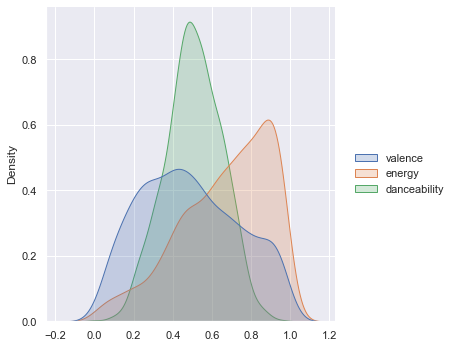

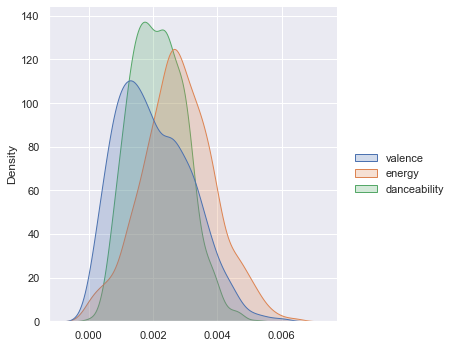

In [178]:
sns.displot(track_features[['valence', 'energy','danceability']], kind='kde', fill=True)

sns.displot(track_features_processed[['valence', 'energy','danceability']], kind='kde', fill=True)
# plt.xlim(-0.002, 0.008)


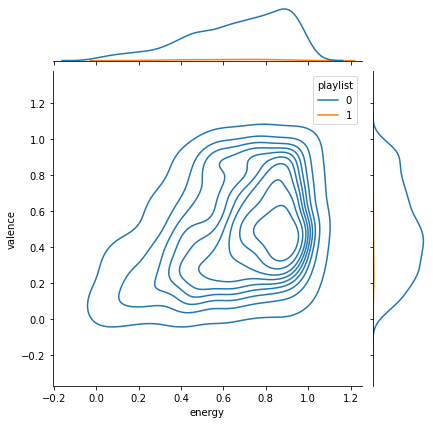

In [103]:
sns.jointplot(data=train_test_dataset, x="energy", y="valence", hue="playlist", kind="kde")

In [29]:
plt.figure(figsize=(10, 10))
matrix = train_test_dataset[['danceability', 'acousticness', 'energy', 'speechiness', 'instrumentalness', 'valence', 'liveness', 'tempo', 'playlist']].corr()
sns.heatmap(matrix, annot=True)
plt.show()